In [1]:
import os
import shutil
import numpy as np
import pickle
import optuna
import plotly.express as px
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split

from Arwin.dataset.synthetic_dataset import SyntheticDataset
from Arwin.model.trainer import Trainer
from Arwin.model.deeponet import *
from Arwin.src.utils import collate_fn_fixed

from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
data_path = 'Arwin/dataset/synthetic_dataset.pkl'

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
synthetic_dataset = SyntheticDataset(100000, 128, padding=False, verbose=True)

with open(data_path, 'wb') as f:
    pickle.dump(synthetic_dataset, f)

Sampling Functions from Beta Distribution 1/3 with a=2, b=5: 100%|██████████| 33333/33333 [02:05<00:00, 266.47it/s]
Sampling Functions from Beta Distribution 2/3 with a=3, b=3:  33%|███▎      | 10882/33333 [00:37<01:07, 333.66it/s]

In [2]:
synthetic_dataset = pickle.load(open(data_path, 'rb'))

[-2.15035028 -2.04386119 -1.93700225 -1.82989286 -1.72265612 -1.61541823
 -1.50830777 -1.40145618 -1.29499655 -1.18906442 -1.08379413 -0.97932509
 -0.87579237 -0.77333377 -0.67208549 -0.57218301 -0.47376033 -0.37694924
 -0.28187997 -0.18867889 -0.09747018 -0.00837415  0.07849316  0.16302006
  0.24509921  0.32462853  0.40151085  0.47565566  0.54697717  0.61539695
  0.68084235  0.74324762  0.80255344  0.85870765  0.91166504  0.96138793
  1.00784566  1.05101505  1.09087915  1.12742903  1.16066362  1.19058792
  1.21721382  1.24056071  1.26065404  1.27752686  1.29121747  1.30177001
  1.30923548  1.31366998  1.3151347   1.31369519  1.30942302  1.30239302
  1.29268431  1.28037978  1.26556535  1.24832861  1.2287625   1.20695851
  1.18301396  1.15702362  1.12908484  1.09929755  1.06775826  1.03456659
  0.99982014  0.9636163   0.9260515   0.88722098  0.84721737  0.80613331
  0.7640585   0.72107948  0.67728151  0.63274718  0.58755582  0.54178372
  0.49550493  0.4487896   0.40170442  0.35431444  0

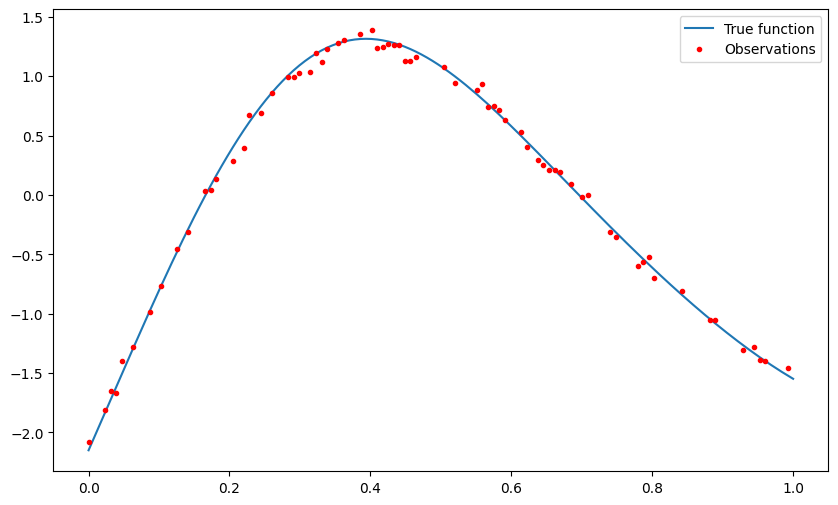

In [ ]:
""" Visualize dataset """

X = np.linspace(0, 1, 128)

for function_values, observations in synthetic_dataset:
    print(function_values)
    observation_values, observation_time_points = observations
    print(observation_time_points)
    print(observation_values)

    plt.figure(figsize=(10,6))
    plt.plot(X, function_values, label='True function')
    plt.plot(observation_time_points, observation_values, marker='.', color='red', linestyle='None', label='Observations')
    plt.legend()
    plt.show()
    break

Only Transformer Encoder, Full Transformer would also require true function values shifted by one which goes against the specifications of the task. Maybe try only Transformer Decoder.

**DeepONet:**

takes two inputs [u(x1), u(x2), . . . , u(xm)] and y in our case u are the random functions and x the signals/observations. y are the points at which the output function is evaluated in our case that should be the points one the fine grid of 128 points. The network wants to learn an operator G in our case that would be the true underlying function.

 <img src="DeepONet.png"  style="width: 50%; height: auto;"/>
 
First there is a “trunk” network, which takes y as the input and outputs $[t_1, t_2, . . . , t_p]^T ∈ R^p$. We note that the trunk network also applies activation functions in the last layer, i.e., $t_k = σ(·)$ for $k = 1, 2, . . . , p$.<br>
A single branch network takes as input $[u(x_1), u(x_2), . . . , u(x_m)]^T$ and outputs a vector $[b_1, b_2, . . . , b_p]^T ∈ R^p$. Both outputs are merged together like:<br>

$G(u)(y) \approx \sum^p_{k=1} = b_k t_k$

Although bias is not necessary in Theorem 1, adding bias to the last layer of the branch network may increase the performance by reducing the generalization error

All versions of DeepONets are implemented in DeepXDE [15], a user-friendly Python library designed for scientific machine learning: https://github.com/lululxvi/deepxde

In [3]:
""" Prepare dataset """

train_ratio = 0.8
validation_ratio = 0.2
dataset_size = len(synthetic_dataset)
train_size = int(train_ratio * dataset_size)
validation_size = dataset_size - train_size
train_dataset, validation_dataset = random_split(synthetic_dataset, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_fixed)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_fixed)

## Optuna

In [ ]:
def define_model(trial):

    # TODO: make sure that d_model is divisible by heads

    # heads = trial.suggest_int('heads', 1, 8)
    # d_model = trial.suggest_int('d_model', heads * 2, heads * 64)
    # p = trial.suggest_int('p', 16, 256)

    d_model = 128
    heads = 2
    p = 128
    indicator_dim = 128

    deeponet = DeepONetJan(indicator_dim=indicator_dim, d_model=d_model, heads=heads, p=p).to(device)

    return deeponet

def objective(trial):
    
    model = define_model(trial)
    criterion = nn.MSELoss()

    trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    trial.suggest_categorical("optimizer", ["Adam", "AdamW"])
    trial.suggest_categorical("scheduler", ["CombinedScheduler", "InverseSquareRootLR"])

    if trial.params["scheduler"] == "InverseSquareRootLR":
        trial.suggest_float("min_lr", 1e-9, trial.params["lr"], log=True)

    trainer = Trainer(model, criterion, train_loader, validation_loader, modelname="Optuna", epochs=2, optuna_trial=trial, verbose=False)
    #trainer = Trainer(model, criterion, train_loader, validation_loader, modelname="Optuna", epochs=2, optuna_trial=trial, optuna_model=True, verbose=False)
    loss = trainer.fit()
    
    return loss

In [5]:
study = optuna.create_study(
    direction="minimize",
    study_name="lr_optim_scheduler_study",
    storage="sqlite:///Arwin/src/lr_optim_scheduler_study.db", # Save study results in a database
    load_if_exists=True
)
study.optimize(objective, n_trials=50)

pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-15 15:16:27,106] A new study created in RDB with name: lr_optim_scheduler_study
100%|█████████▉| 312/313 [03:58<00:00,  1.31it/s]
[I 2024-11-15 15:24:26,002] Trial 0 finished with value: 0.048984421234504846 and parameters: {'lr': 0.00027462371593934973, 'optimizer': 'AdamW', 'scheduler': 'InverseSquareRootLR', 'min_lr': 9.052582782096155e-06}. Best is trial 0 with value: 0.048984421234504846.
100%|█████████▉| 312/313 [03:58<00:00,  1.31it/s]
[I 2024-11-15 15:32:23,330] Trial 1 finished with value: 0.15596515086351656 and parameters: {'lr': 3.2927842185987376e-05, 'optimizer': 'AdamW', 'scheduler': 'InverseSquareRootLR', 'min_lr': 8.402637359293713e-07}. Best is trial 0 with value: 0.048984421234504846.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Fa

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  42
  Number of complete trials:  8
Best trial:
  Value:  0.04102091352437057
  Params: 
    lr: 0.0004698495364117979
    optimizer: AdamW
    scheduler: InverseSquareRootLR
    min_lr: 1.9166903037985866e-05


## Results of Optuna Study for LR, Optimizer and Scheduler

Best trial:
  Value:  0.04102091352437057
  Params: 
    lr: 0.0004698495364117979
    optimizer: AdamW
    scheduler: InverseSquareRootLR
    min_lr: 1.9166903037985866e-05


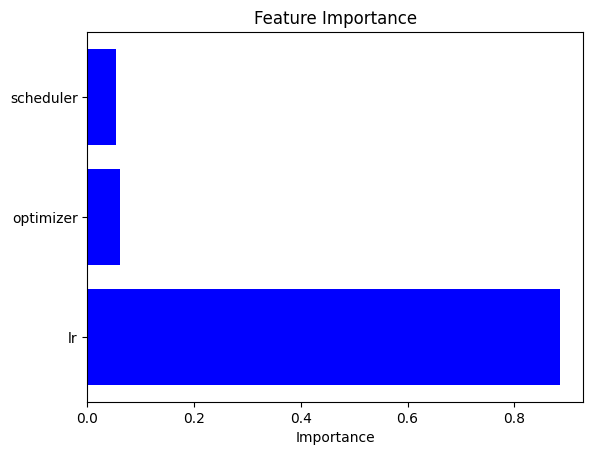

/tmp/ipykernel_1165/1922880279.py:16: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=['lr', 'scheduler'])
[W 2024-11-15 16:51:49,965] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/tmp/ipykernel_1165/1922880279.py:17: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=['lr', 'optimizer'])
[W 2024-11-15 16:51:50,041] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/tmp/ipykernel_1165/1922880279.py:18: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=

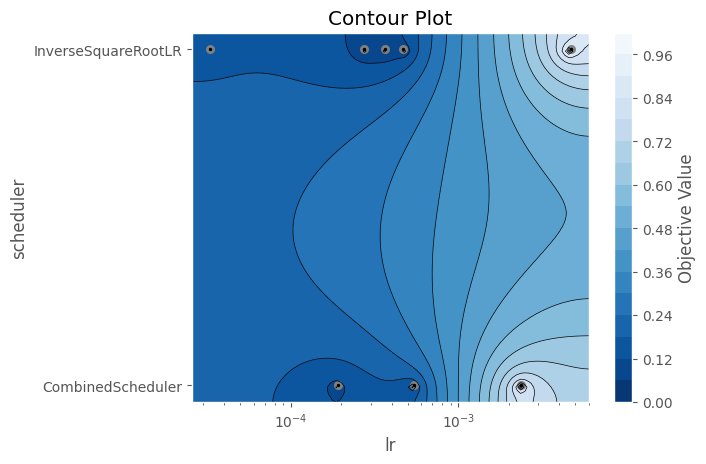

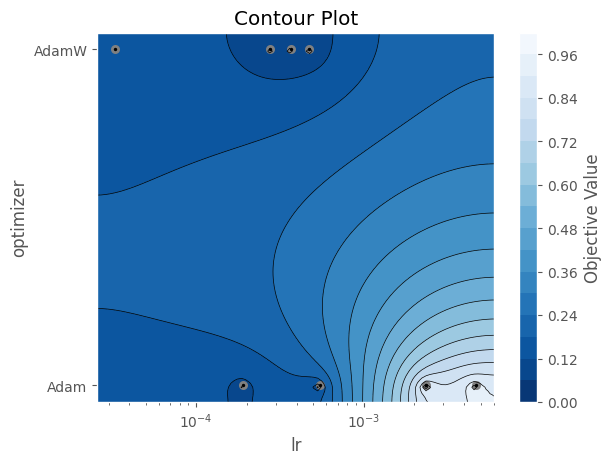

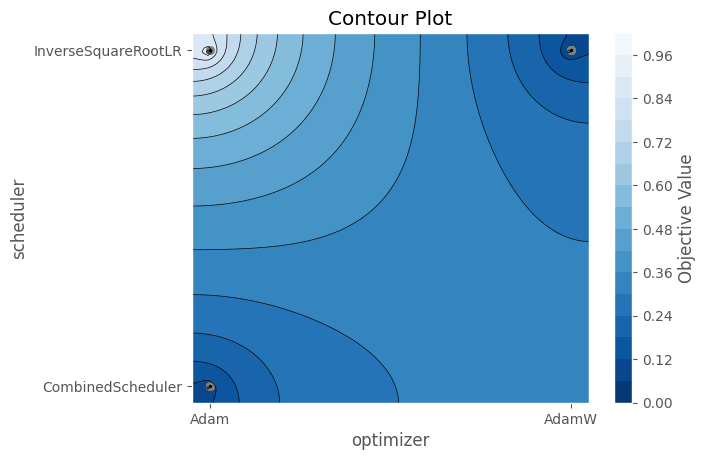

In [6]:
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

optuna_dict = optuna.importance.get_param_importances(study)
plt.barh(list(optuna_dict.keys()), list(optuna_dict.values()), color='blue')
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()

optuna.visualization.matplotlib.plot_contour(study, params=['lr', 'scheduler'])
optuna.visualization.matplotlib.plot_contour(study, params=['lr', 'optimizer'])
optuna.visualization.matplotlib.plot_contour(study, params=['optimizer', 'scheduler'])
plt.show()

In [5]:
TBOARD_LOGS = os.path.join("./Arwin", "tboard_logs", "model_Jan")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS) 
writer = SummaryWriter(TBOARD_LOGS)

indicator_dim = 128

X = np.linspace(0, 1, indicator_dim)
fine_grid_points = torch.tensor(X,dtype=torch.float32)
fine_grid_points_batch = torch.stack([fine_grid_points for _ in range(BATCH_SIZE)], dim=0).to(device)

deeponet = DeepONetJan(fine_grid_points_batch, indicator_dim=indicator_dim, d_model=256, heads=2, p=164).to(device)
criterion = nn.MSELoss()
trainer = Trainer(model=deeponet, criterion=criterion, train_loader=train_loader, valid_loader=validation_loader, modelname="model_Jan", n_iters=2, writer=writer)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [ ]:
trainer.fit()

Ep 0 Iter 1: Loss=8.95072:   0%|          | 0/1250 [00:01<?, ?it/s]

Valid loss @ iteration 0: Loss=7.961127477533677


Ep 0 Iter 200: Loss=0.13244:  16%|█▌        | 200/1250 [03:14<17:39,  1.01s/it]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Ep 0 Iter 251: Loss=0.14731:  20%|██        | 250/1250 [04:02<15:40,  1.06it/s]

Valid loss @ iteration 250: Loss=0.13725040049529544


Ep 0 Iter 460: Loss=0.1009:  37%|███▋      | 460/1250 [07:24<13:00,  1.01it/s] 

: 